In [7]:
%load_ext autoreload
%autoreload 2

In [ ]:
u_feed = {}
for p in rec_p:
    while True:
        try:
            score = int(input(f"Rate Program {p} (0-5): "))
            if 0 <= score <= 5:
                u_feed[p] = score
                break
            else:
                print("Please enter a valid score between 0 and 5.")
        except ValueError:
            print("Please enter a valid integer.")


In [ ]:
# Adjust Q-values based on user feedback
for p, score in u_feed.items():
    if score == 0:
        # Strong disagreement: Heavily penalize the Q-value
        q_dict[p] -= w_feed * 10
    else:
        # Adjust Q-value based on the user's score (higher score = higher preference)
        q_dict[p] += w_feed * score

# Recommend the top N programs again after incorporating user feedback
revised = sorted(q_dict, key=q_dict.get, reverse=True)[:top_n]

print("\nTop recommended programs after incorporating user feedback:")
for i, p in enumerate(revised, 1):
    print(f"{i}. Program {p}")

In [ ]:
import numpy as np
import random

# Initialize program details
n_p = 20
progs = [chr(65 + i) for i in range(n_p)]
p_s = {p: np.random.randint(40, 100, size=6) for p in progs}
p_sal = {p: np.random.randint(5, 10) for p in progs}
p_vers = {p: np.random.randint(5, 10) for p in progs}
p_elg = {p: np.random.randint(50, 90) for p in progs}


u_s = np.random.randint(50, 100, size=6).astype(float)
u_elg = float(np.random.randint(50, 90))  
w_sal = 0.6
w_vers = 0.3
w_elg = 0.1

q_vals = {p: 0.0 for p in progs}
lr = 0.1
gamma = 0.9
f_adj = 0.5
epsilon_threshold = 0.01
top_n = 5


questions_pool = np.random.rand(1000)
asked_questions = []

def ask_qs():
    global asked_questions, u_s
    selected_questions = random.sample(list(questions_pool), 6)
    for weight in selected_questions:
        answer = int(input(f"Answer question (0-5): "))
        answer = max(0, min(answer, 5)) 
        u_s += answer * weight  
    asked_questions.extend(selected_questions)
    return u_s

def update_q_vals():
    epsilon = 0
    for p in progs:
        sim = np.dot(u_s, p_s[p]) / (np.linalg.norm(u_s) * np.linalg.norm(p_s[p]))
        elg_impact = u_elg / p_elg[p]
        r_sal = p_sal[p] * sim
        r_vers = p_vers[p] * sim
        r_elg = elg_impact * 10
        reward = w_sal * r_sal + w_vers * r_vers + w_elg * r_elg
        max_q = max(q_vals.values())
        old_q = q_vals[p]
        q_vals[p] = (1 - lr) * q_vals[p] + lr * (reward + gamma * max_q)
        
    return q_vals, old_q

def get_feedback(rec):
    global progs
    fb = {p: int(input(f"Rate {p} (0-5): ")) for p in rec}
    for p, score in fb.items():
        if score == 0:
            progs.remove(p)
            del q_vals[p]
        else:
            q_vals[p] += f_adj * (score - 2) * 5

max_ep = 10
for ep in range(max_ep):
    u_s = ask_qs()
    q_vals, old_q = update_q_vals()
    epsilon=abs(q_vals-old_q)
    print(q_vals, old_q)
    if len(progs) < top_n:
        break
    
    if epsilon < epsilon_threshold:
        rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
        get_feedback(rec)
        satisfied = input("Satisfied? (yes/no): ").strip().lower()

        if satisfied == 'yes':
            break

if len(progs) >= top_n:
    print("\nFinal Recommendations:")
    rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
    for i, p in enumerate(rec, 1):
        print(f"{i}. {p}")
else:
    print("\nNot enough programs left to recommend. Test ends.")


In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mean(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar




class Generator(nn.Module):
    def __init__(self, z_dim=20, img_dim=784):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set up the dataset and data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

from torchvision import datasets, transforms

# Update transform to scale values to [0, 1] instead of using normalization
transform = transforms.Compose([
    transforms.ToTensor()  # Automatically scales pixel values to [0, 1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)


In [ ]:
import torch.optim as optim

# Initialize the VAE model, optimizer, and loss function
vae = VAE(latent_dim=20)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(reconstructed_x, x, mu, logvar):
    # Ensure x and reconstructed_x are of type float
    x = x.float()
    reconstructed_x = reconstructed_x.float()
    
    # Binary Cross Entropy for Reconstruction Loss
    recon_loss = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    
    # KL Divergence for Latent Space Regularization
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence


# Training loop for VAE
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784)
        x = (x + 1) / 2 # Flatten images to 784 dimensions
        reconstructed, mu, logvar = vae(x)
        loss = vae_loss(reconstructed, x, mu, logvar)
        
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], VAE Loss: {total_loss / len(train_loader.dataset):.4f}")


In [ ]:
# Initialize the GAN models, optimizers, and loss function
generator = Generator(z_dim=20, img_dim=784)
discriminator = Discriminator(img_dim=784)
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
criterion = nn.BCELoss()

# Training loop for GAN
for epoch in range(num_epochs):
    for real, _ in train_loader:
        real = real.view(-1, 784)  # Flatten images to 784 dimensions
        batch_size = real.size(0)
        
        # Labels
        labels_real = torch.ones(batch_size, 1)
        labels_fake = torch.zeros(batch_size, 1)

        # Train Discriminator
        noise = torch.randn(batch_size, 20)  # Latent dimension is 20
        fake = generator(noise)
        
        disc_real = discriminator(real)
        disc_fake = discriminator(fake.detach())
        loss_disc = criterion(disc_real, labels_real) + criterion(disc_fake, labels_fake)
        
        disc_optimizer.zero_grad()
        loss_disc.backward()
        disc_optimizer.step()

        # Train Generator
        output = discriminator(fake)
        loss_gen = criterion(output, labels_real)
        
        gen_optimizer.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Disc Loss: {loss_disc:.4f}, Gen Loss: {loss_gen:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Generate VAE samples
with torch.no_grad():
    z = torch.randn(16, 20)  # Sample from Gaussian
    vae_generated_images = vae.decode(z).view(-1, 28, 28).numpy()

# Generate GAN samples
with torch.no_grad():
    z = torch.randn(16, 20)
    gan_generated_images = generator(z).view(-1, 28, 28).numpy()

# Plot VAE generated images
fig, axes = plt.subplots(2, 8, figsize=(10, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(vae_generated_images[i], cmap='gray')
    ax.axis('off')
plt.suptitle("VAE Generated Samples")
plt.show()

# Plot GAN generated images
fig, axes = plt.subplots(2, 8, figsize=(10, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gan_generated_images[i], cmap='gray')
    ax.axis('off')
plt.suptitle("GAN Generated Samples")
plt.show()


In [3]:
from IRT import AdaptiveMIRT
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
model2 = AdaptiveMIRT(select_noise=0.1, n_items=10000, n_traits=6, verbose=False)

In [4]:


# Initialize AdaptiveMIRTv2 with 10,000 items


# Number of adaptive steps
n_steps = 100

# Track time for each iteration
iteration_times = []

# Run adaptive testing with tqdm progress bar
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    
    # Select the next item and simulate a response
    model2.next_item()
    model2.sim_resp()
    
    # Update theta estimates
    model2.update_theta()




Running Adaptive Testing: 100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


In [100]:
from debugging import AdaptiveMIRTvD
dev_model = AdaptiveMIRTvD(n_items=1000, n_traits=6, verbose=False)
n_steps = 300
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    item = dev_model.next_item()
    resp = dev_model.sim_resp()
    dev_model.update_theta()

Running Adaptive Testing: 100%|██████████| 300/300 [00:06<00:00, 47.30it/s]


In [107]:
from IRT import AdaptiveMIRT
vanila = AdaptiveMIRT(n_items=1000, n_traits=6, verbose=False)
n_steps = 300
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    item = vanila.next_item()
    resp = vanila.sim_resp()
    vanila.update_theta()

Running Adaptive Testing: 100%|██████████| 300/300 [00:16<00:00, 18.08it/s]


In [109]:
from NewIRT import AdaptiveMIRTNew
model = AdaptiveMIRTNew(n_items=1000, n_traits=6, verbose=False)
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    item = model.next_item()
    resp = model.sim_resp()
    model.update_theta()


Running Adaptive Testing: 100%|██████████| 300/300 [00:07<00:00, 40.86it/s]


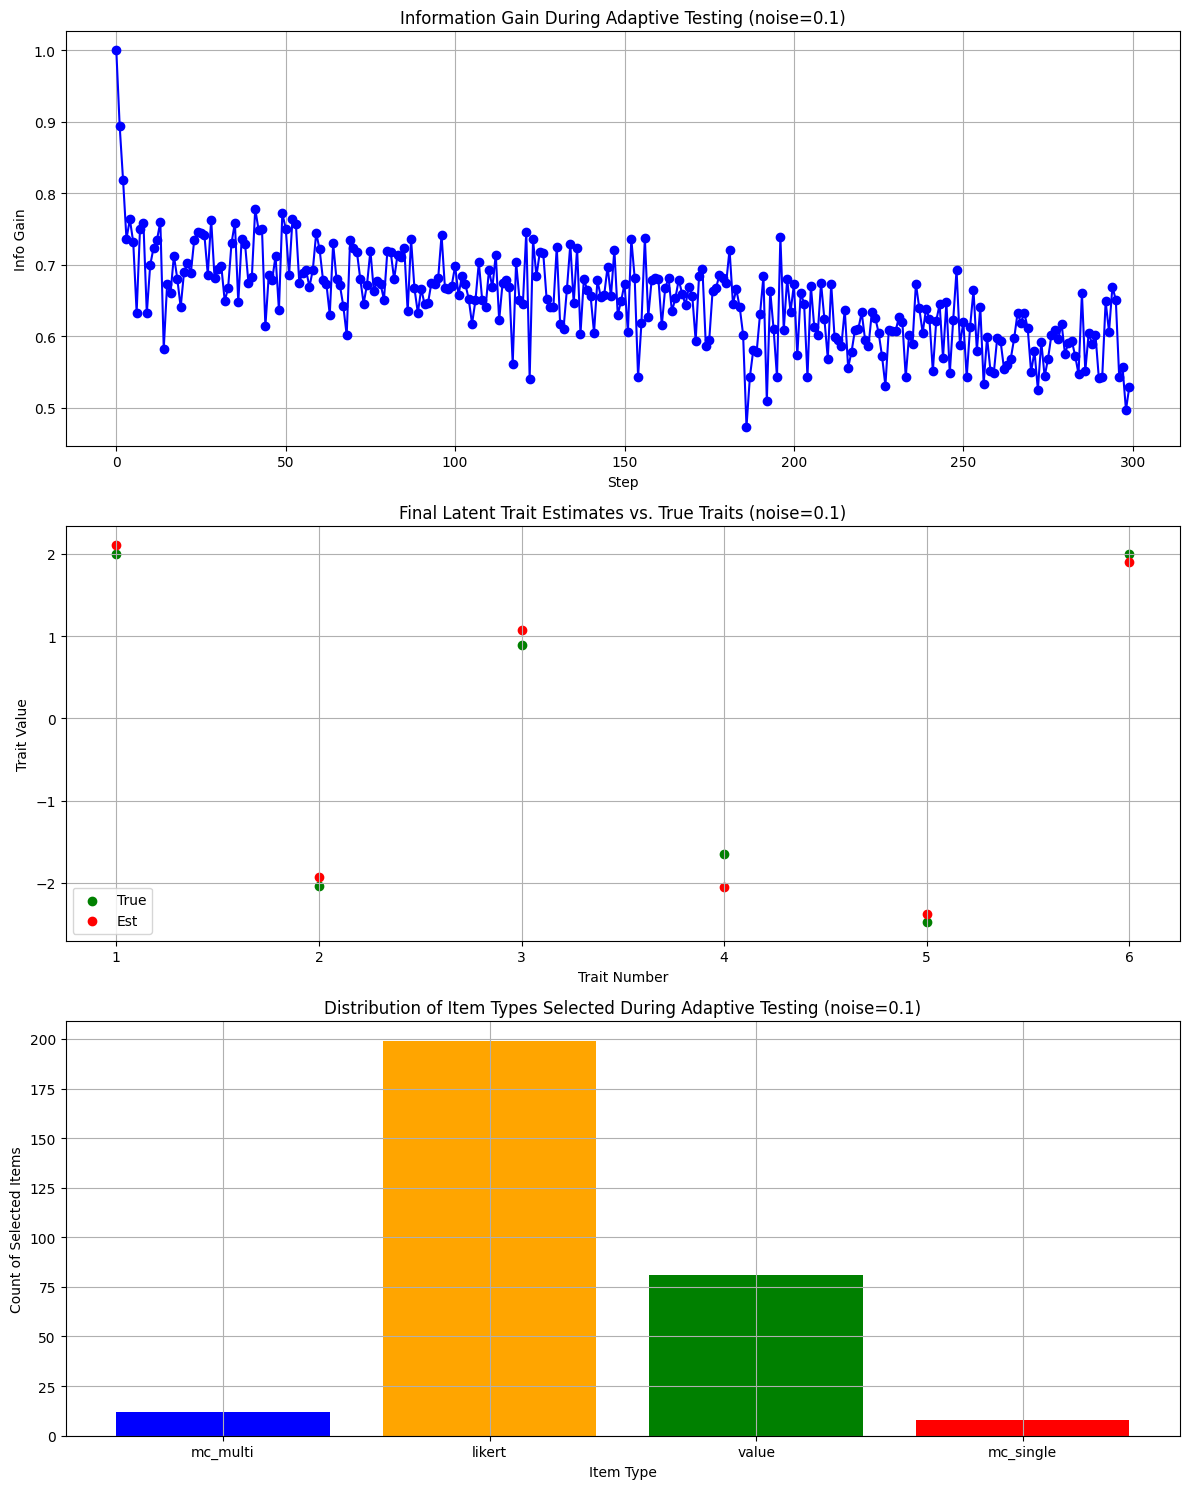

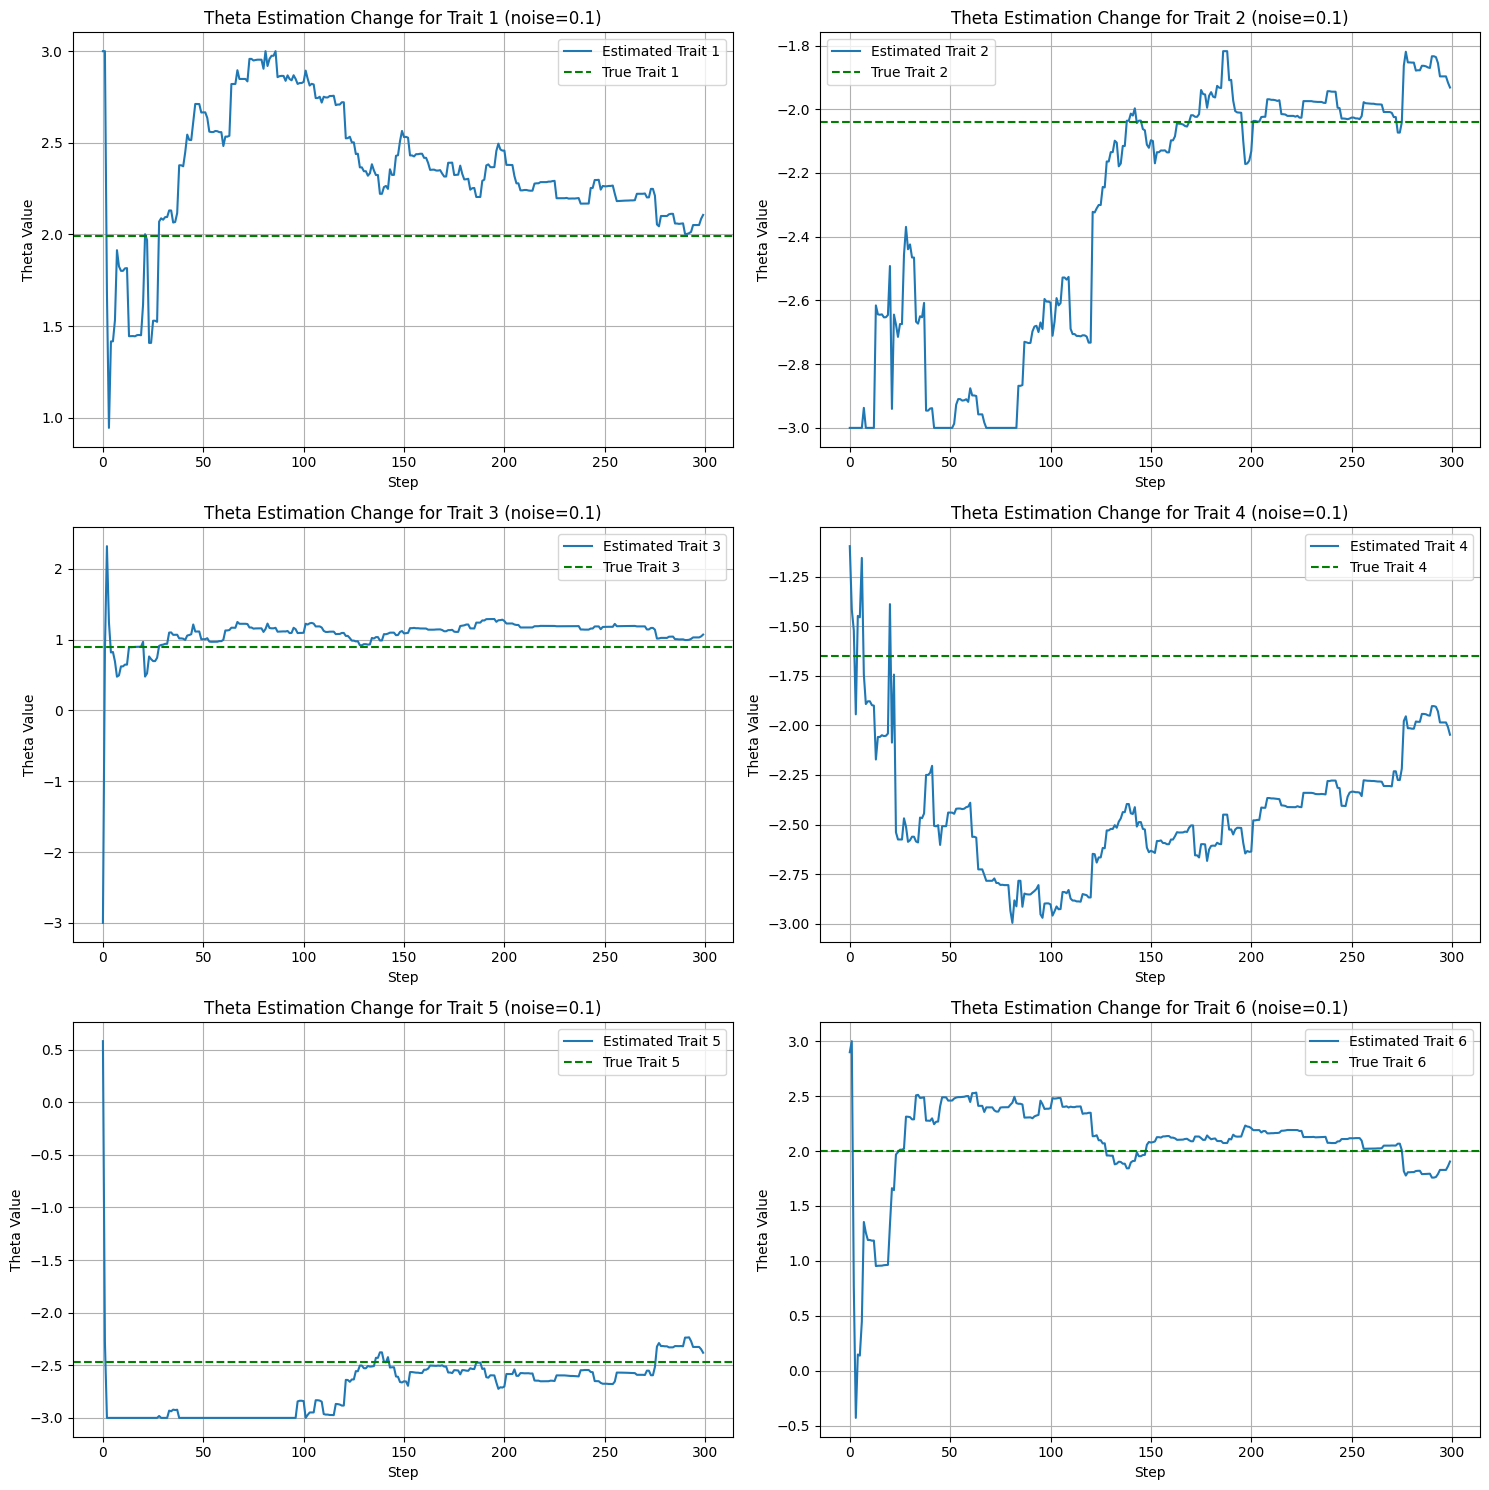

In [110]:
model.plot_results(save_fig=False)

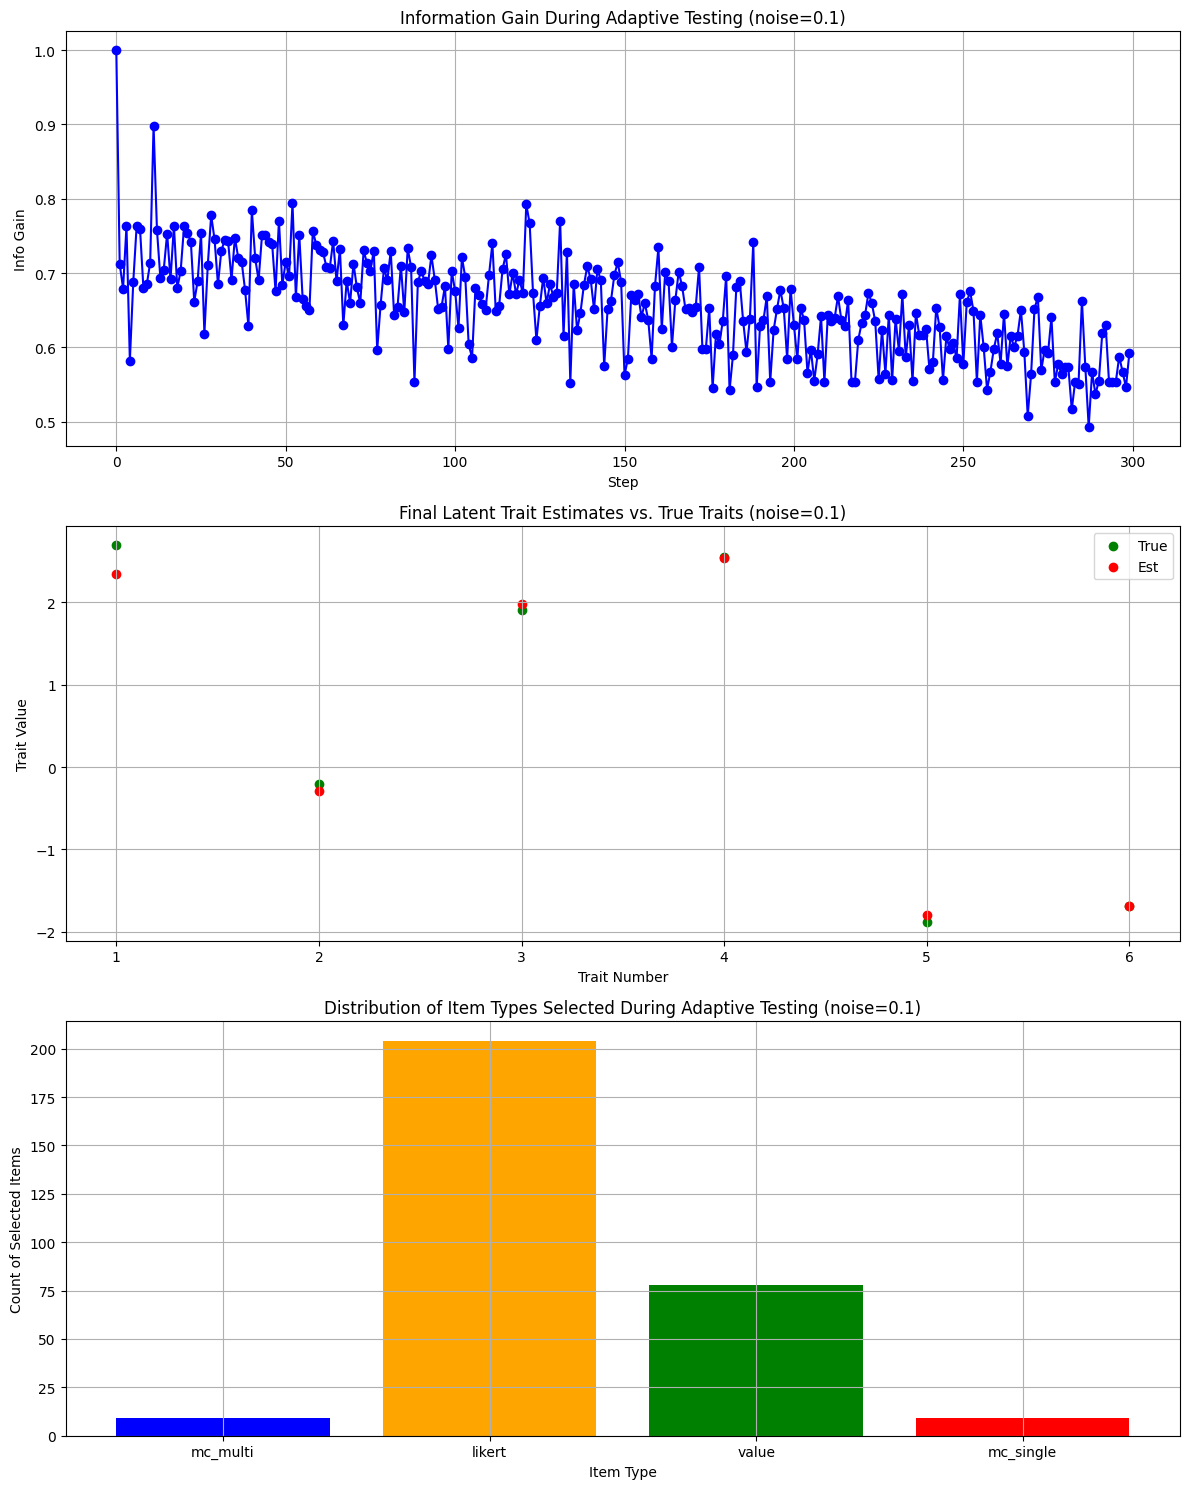

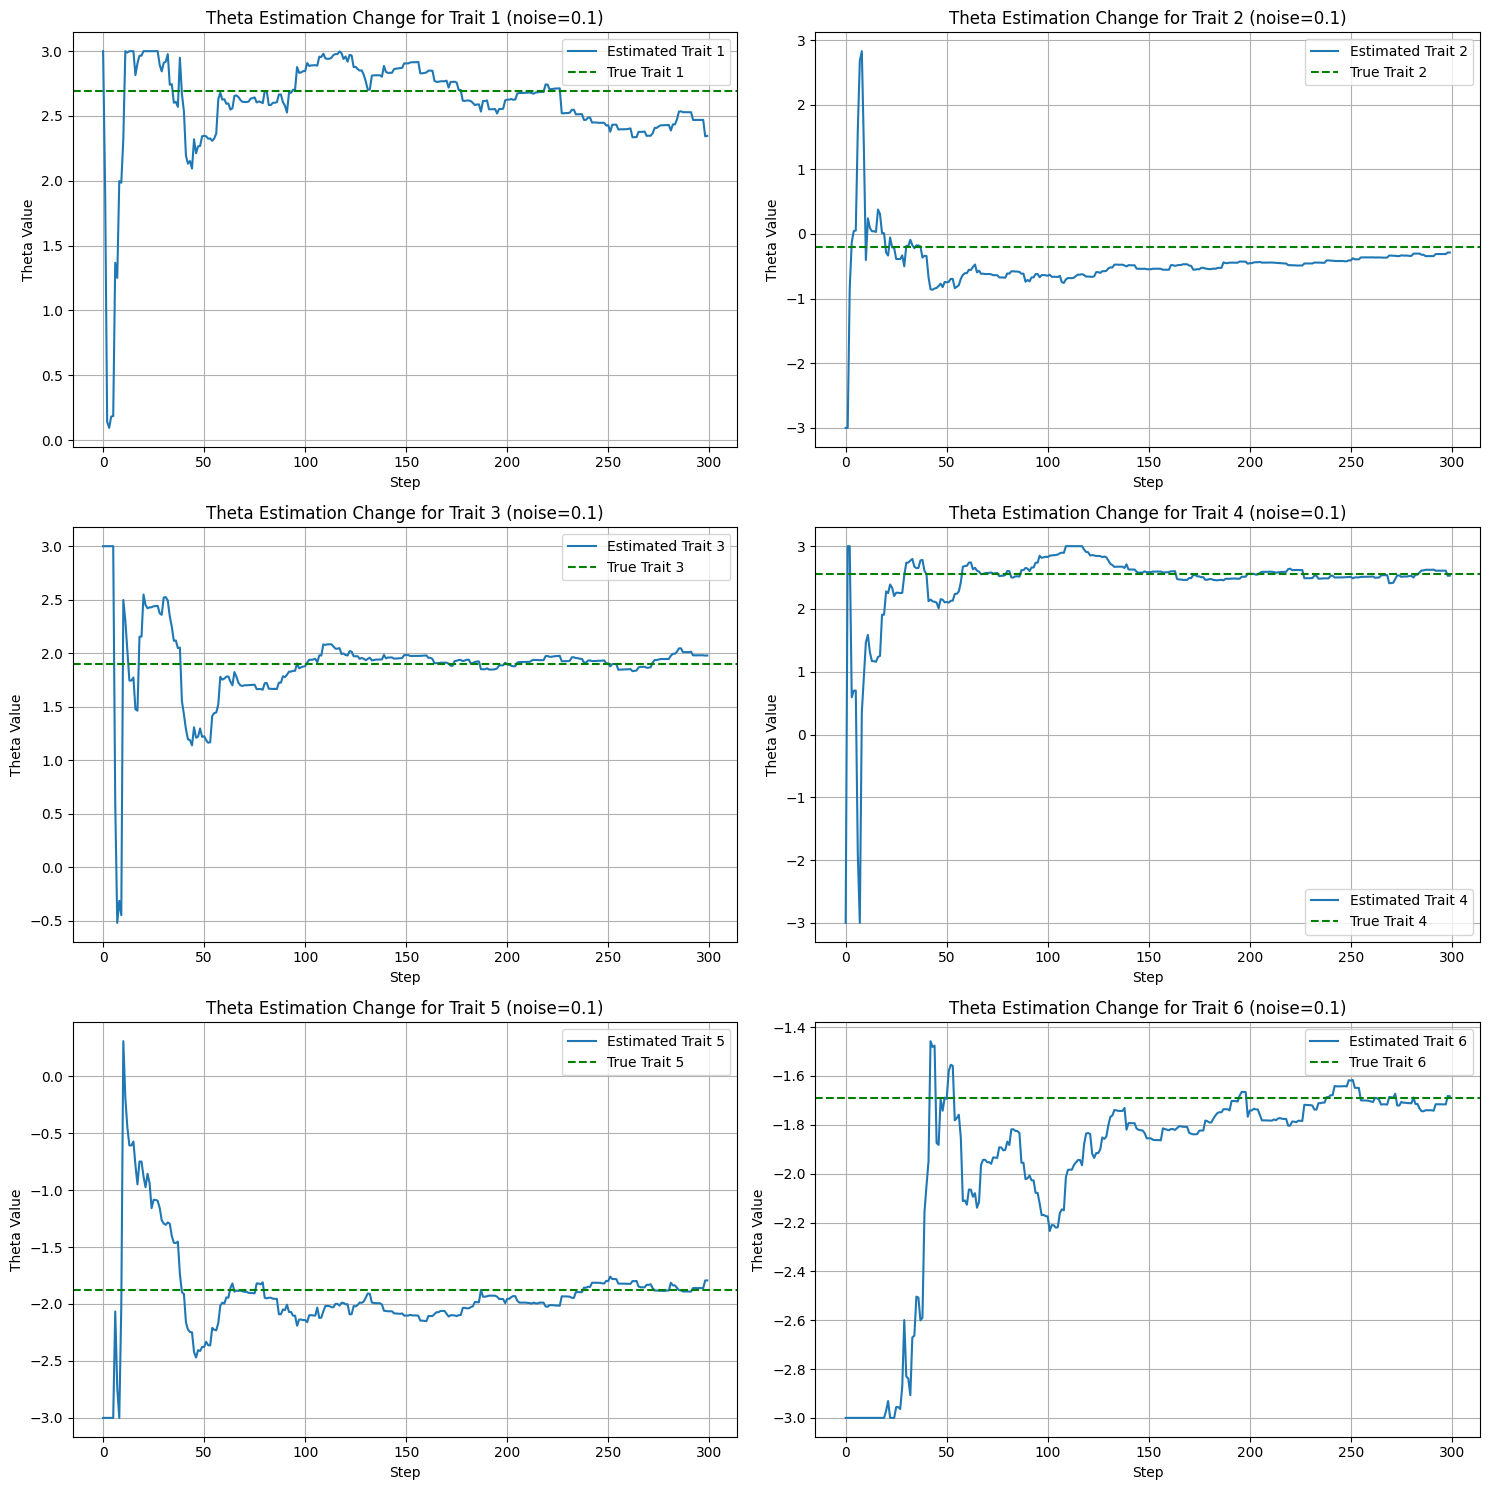

In [98]:
model.plot_results(save_fig=False)

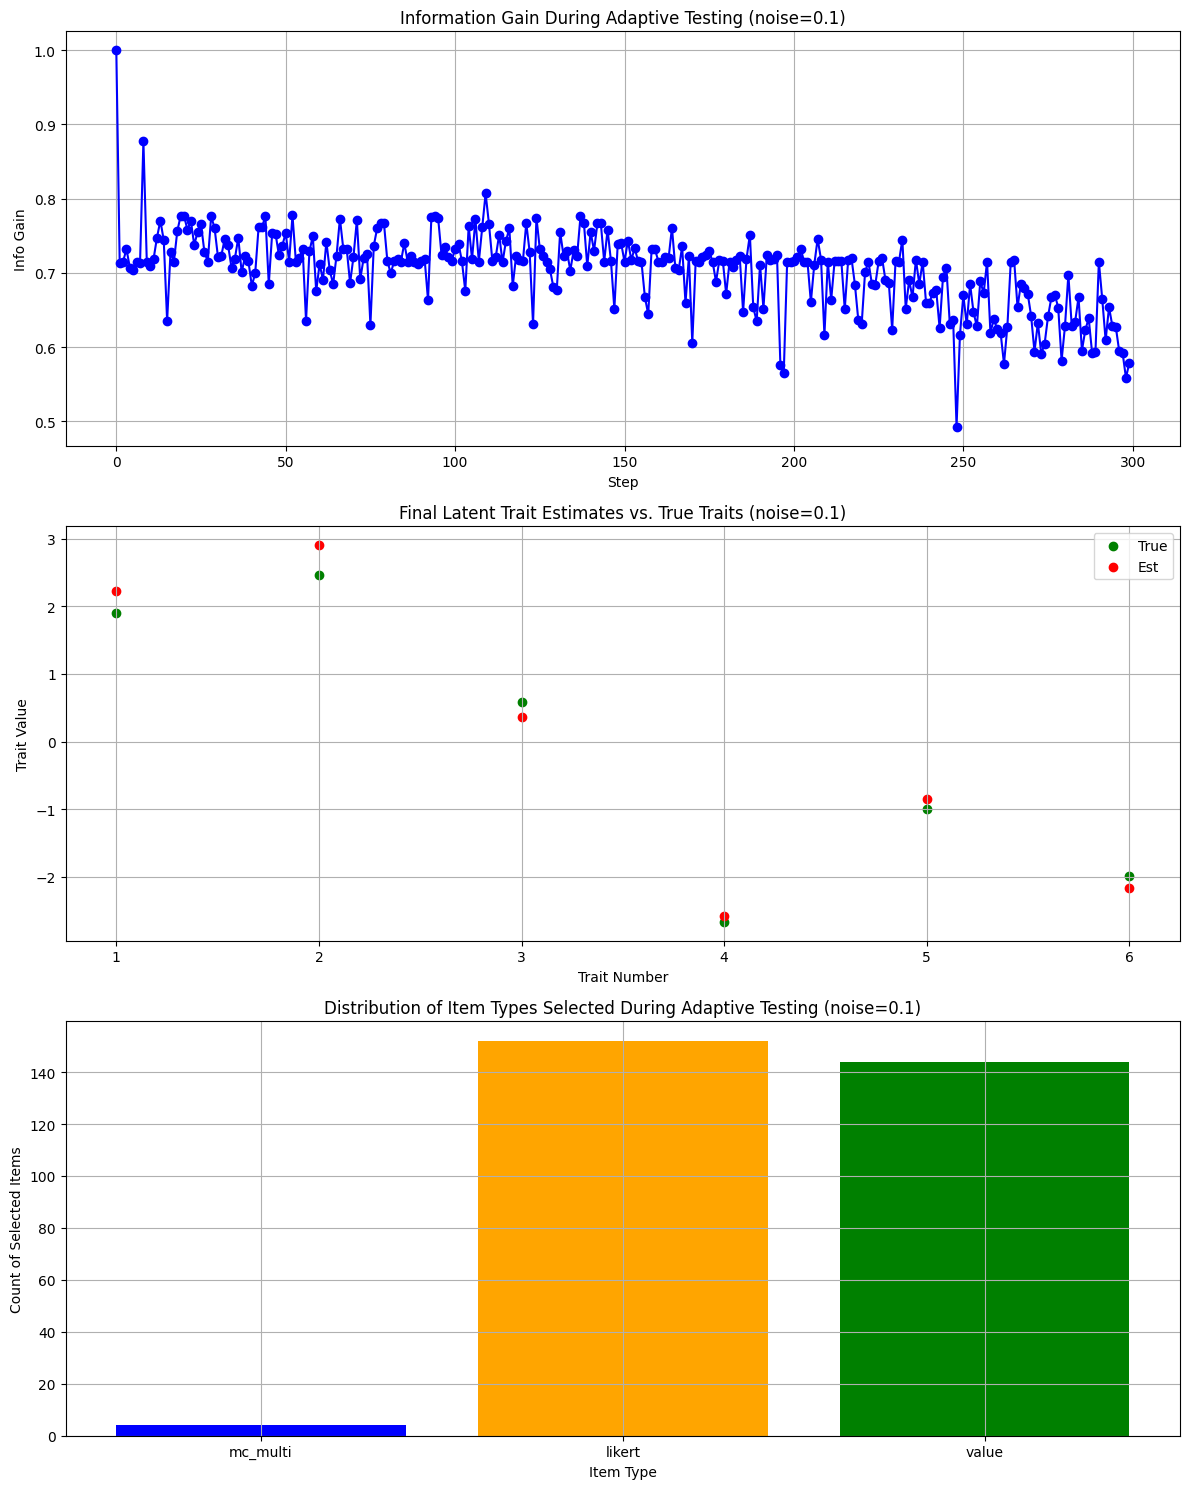

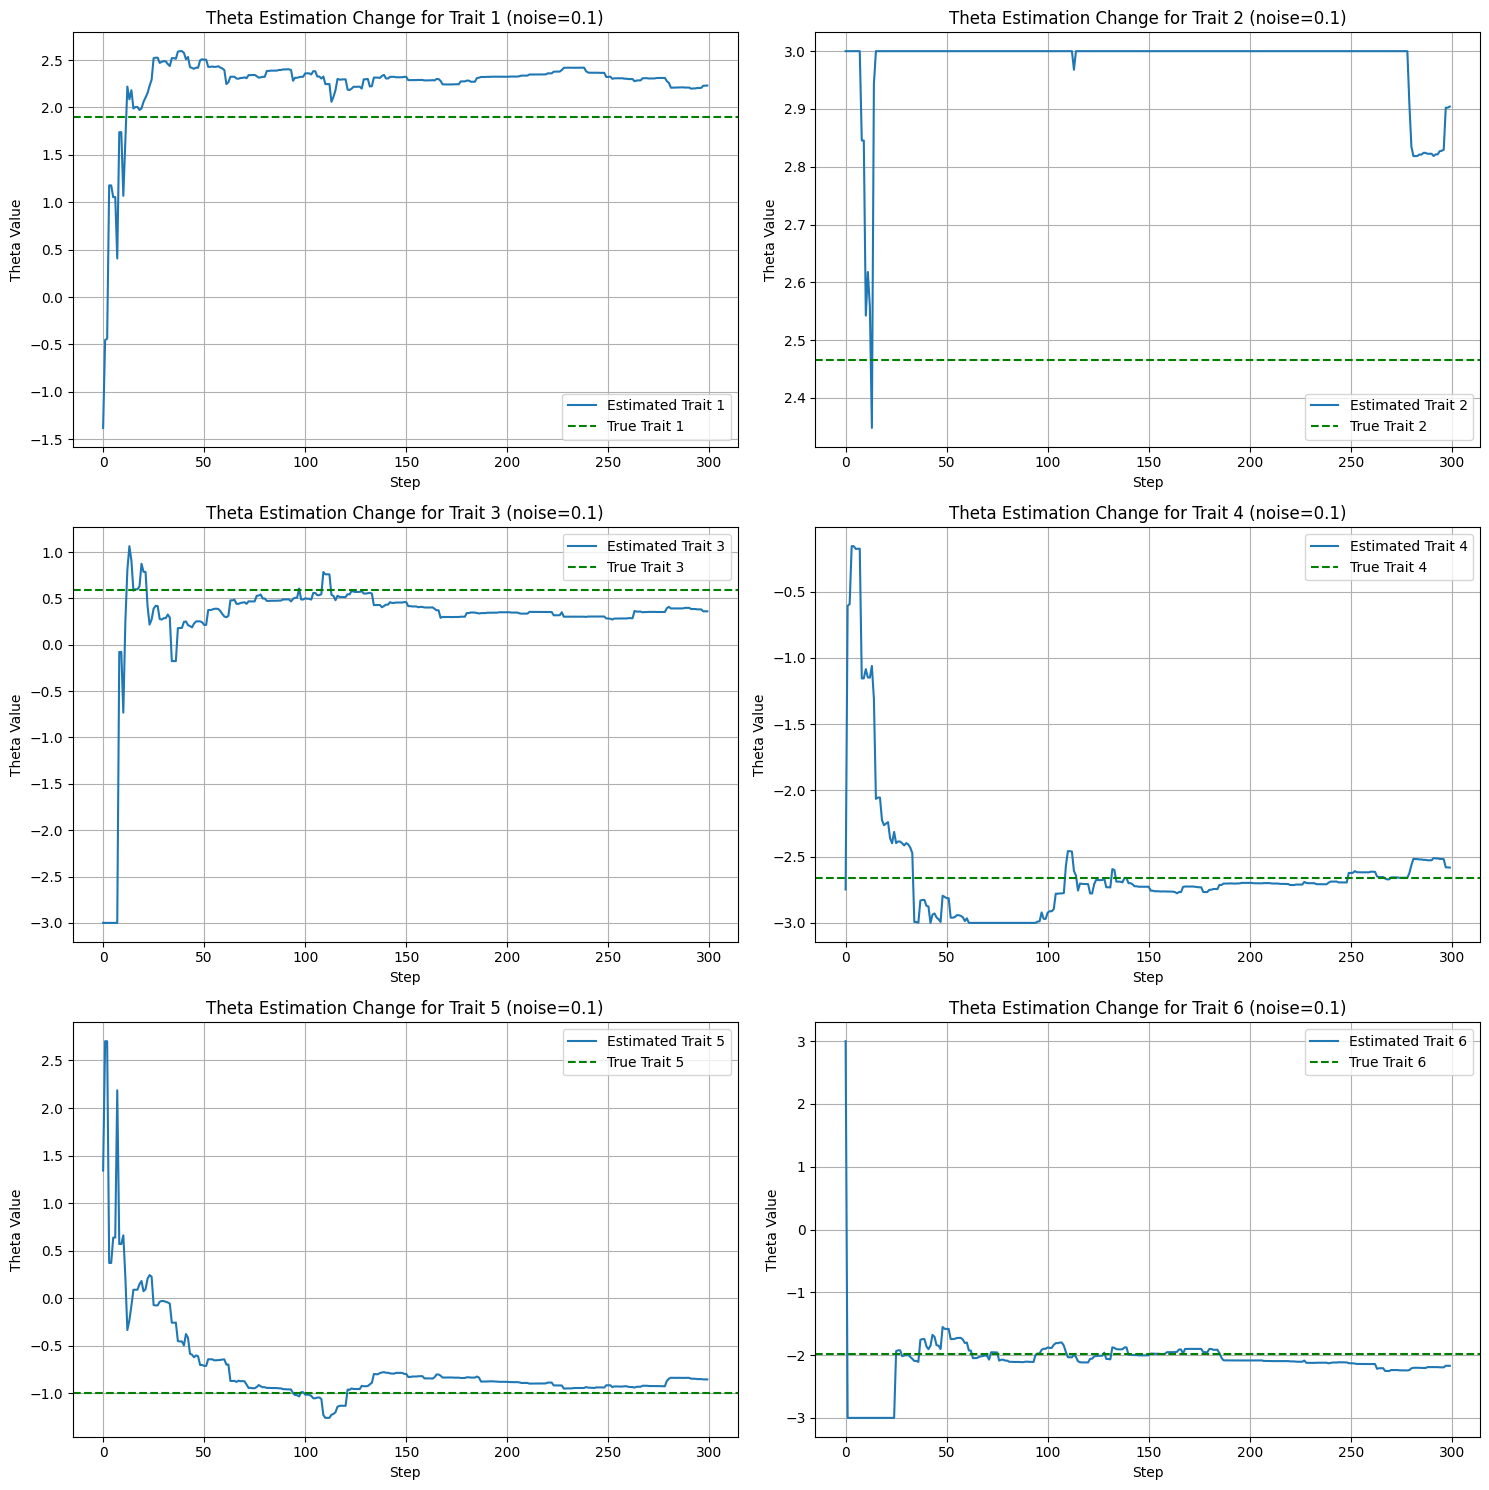

In [99]:
vanila.plot_results(save_fig=False)

In [21]:
import numpy as np

# Setup
n_items = 1000
probs = [0.4, 0.2, 0.2, 0.1, 0.1]
item_opts = ['likert', 'binary', 'value', 'mc_single', 'mc_multi']
item_types = np.random.choice(item_opts, size=n_items, p=probs)

# Subset of indices
x = np.random.randint(0, n_items, size=100)

# Dictionary to store the subset of x for each type
subset_x_by_type = {}

# Find the subset of x for each type


# Display the subset for each type
print("Subset of x by type:", subset_x_by_type)


Subset of x by type: {}


In [ ]:
# %%timeit
for item_type in item_opts:
    # Get indices in x where item_types is equal to item_type
    subset_x = x[item_types[x] == item_type]
    subset_x_by_type[item_type] = subset_x

In [ ]:
# %%timeit
subset_xs = [x[item_types[x] == item_opts[q]] for q in range(len(item_opts))]
subsex = [x[item_types[x] == item] for item in item_opts]

In [ ]:
subsex

In [ ]:
subset_xs

In [ ]:
subset_x_by_type

In [1]:
import time
import numpy as np
from tqdm import tqdm
from NewIRT import AdaptiveMIRTv2

# Initialize AdaptiveMIRTv2 with test parameters
n_items = 1000    # Total number of items in the test pool
n_traits = 6      # Number of latent traits to estimate
n_steps = 100     # Number of adaptive testing steps
select_noise = 0.1  # Noise factor for item selection

# Instantiate the model
model = AdaptiveMIRTv2(select_noise=select_noise, n_items=n_items, n_traits=n_traits, verbose=False)

# Track timing for each adaptive step to observe performance improvements
iteration_times = []

# Run the adaptive testing loop
for step in tqdm(range(n_steps), desc="Running Optimized Adaptive Testing"):
    start_time = time.time()
    
    # Select the next item and simulate a response
    model.next_item()
    model.simulate_response()
    
    # Update theta estimates every 5 steps (for efficiency)
    if (step + 1) % 5 == 0:
        model.update_theta()
    
    # Record the elapsed time for this iteration
    iteration_times.append(time.time() - start_time)

# Plotting results using the class's plot_results method
model.plot_results(plot_info=True, plot_theta=True, no_show=False, save_fig=False)


Running Optimized Adaptive Testing:   3%|▎         | 3/100 [00:00<00:02, 35.22it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [2]:
model.responses

[1, 1, 1, array([0, 1, 0, 1])]

In [20]:
xxx = [x[model2.item_types[x]== item] for item in model.item_opts]

NameError: name 'x' is not defined

In [59]:
likerts = x[model.item_types[x]=='likert']

In [74]:
lpb = model.scale_prob(model.a_params[likerts], model.true_th, model.thresholds[likerts].T)

In [76]:
dff = model.a_params[likerts] @ model.true_th


ValueError: object too deep for desired array

In [92]:
resp = [np.argmax(np.random.multinomial(1,p))+1 for p in lpb.T]

In [100]:
lpb.T[resp].shape

(35,)

In [99]:
model.a_params.shape

(1000, 6)

In [26]:
selected = np.asarray(model.sel_items, dtype=int)

# Create subsets of selected items by type
xy = [selected[model.item_types[selected] == item_type] for item_type in model.item_opts]

In [54]:
pb = model.bin_prob(model.a_params[xy[1]],model.bin_b[xy[1]], model.est_th)

In [56]:
fg*np.log(pb+1e-8)+(1-fg)*np.log(1-pb+1e-8)

array([-1.85855968])

In [48]:
model.est_th[xy[1]] 

IndexError: index 885 is out of bounds for axis 0 with size 6

In [50]:
fg = np.array(model.responses)
fg

array([0])

In [39]:
aa = np.random.rand(1000, 6)  # Replace with your actual data

# Array of indices b (e.g., length 10)
bb = np.array([1, 5, 10, 50, 100, 150, 200, 250, 300, 350])

# Select rows of a based on indices in b
cc = aa[bb]

In [40]:
cc

array([[0.06143074, 0.2314039 , 0.24448349, 0.79507677, 0.58579589,
        0.14635856],
       [0.63706055, 0.95330077, 0.56318102, 0.99397019, 0.44116   ,
        0.07690867],
       [0.2033581 , 0.83755831, 0.25325864, 0.05751636, 0.77024365,
        0.22954901],
       [0.93613209, 0.6314675 , 0.52434157, 0.50763124, 0.7505899 ,
        0.97916401],
       [0.76042547, 0.32611368, 0.41111049, 0.41301441, 0.39822741,
        0.47535965],
       [0.99553957, 0.24506018, 0.70935715, 0.05362686, 0.84446481,
        0.01807199],
       [0.33153047, 0.68362539, 0.24957518, 0.63290601, 0.81251857,
        0.8151278 ],
       [0.15298281, 0.26776474, 0.26999244, 0.00124209, 0.12328494,
        0.84348917],
       [0.64709582, 0.36054719, 0.8021187 , 0.70426311, 0.53422537,
        0.77529375],
       [0.24784509, 0.42136373, 0.04306088, 0.79759435, 0.13230902,
        0.91863845]])

In [ ]:
a_params = np.random.randn(n_items, 6)
bin_b = np.random.randn(n_items)
theta0 = np.random.uniform(-3, 3, size=6)

In [ ]:
from scipy.special import expit
def bin_prob(a, b, theta):
    return expit(a @ theta - b)

In [ ]:
resp = np.random.binomial(1, prob_list)
resp

In [ ]:
%%timeit
probs = []
ll = 0
resps = []
for i in subset_xs[0]:
    prob = bin_prob(a_params[i], bin_b[i], theta0)
    prob = np.clip(prob, 1e-8, 1 - 1e-8)
    probs.append(prob)
    resp = np.random.binomial(1, prob)
    resps.append(resp)
    ll += resp * np.log(prob) + (1-resp) * np.log(1-prob)   

In [ ]:
%%timeit
p = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)
r = np.random.binomial(1, p)
nll = 0
nll = np.sum(r*np.log(p) + (1-r)*np.log(1-p))

In [ ]:
nll==ll

In [ ]:
%%timeit
prob_list = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)

In [ ]:
resp_list = 

In [ ]:
# Sampling from GAN latent space after training
with torch.no_grad():
    z = torch.randn(16, 20)  # Latent space dimension is 20
    gan_generated_images = generator(z).view(-1, 28, 28).numpy()
